<a href="https://colab.research.google.com/github/Anze-/datathon2k25/blob/alberto/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

# 1. Set up working environment

In [32]:
import pandas as pd
import numpy as np
import csv

In [33]:
# enable GPU if needed, GPU can speed up your vector embedding if you computing these vectors locally (not using API)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [34]:
import os
import json
import chromadb
import openai
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = open('api.key').read()[:-1]

FileNotFoundError: [Errno 2] No such file or directory: 'api.key'

# 2. Knowledge Base Preparation

## 2.1 World Cities

In [35]:
cities_path = './data/geonames-all-cities-with-a-population-1000.csv'
cdb = pd.read_csv(cities_path, sep=';', header=0)

In [36]:
cdb[~pd.isna(cdb['Alternate Names'])] 

,Geoname ID,Name,ASCII Name,Alternate Names,Feature Class,Feature Code,Country Code,Country name EN,Country Code 2,Admin1 Code,Admin2 Code,Admin3 Code,Admin4 Code,Population,Elevation,DIgital Elevation Model,Timezone,Modification date,LABEL EN,Coordinates
0,3948841,Huayllati,Huayllati,"Huaillati,Huayllati",P,PPLA3,PE,Peru,NaN,03,0307,030704,NaN,515,NaN,3467,America/Lima,2020-05-13,Peru,"-13.92862, -72.48496"
6,2093967,Kimbe,Kimbe,"Kimbe,jin bei,kymbh,Кимбе,کمبے,کیمبه,金貝",P,PPLA,PG,Papua New Guinea,NaN,17,NaN,NaN,NaN,18847,NaN,27,Pacific/Port_Moresby,2015-04-06,Papua New Guinea,"-5.55085, 150.13766"
7,1680116,NIA Valencia,NIA Valencia,"Dakbayan sa Valencia,Kota Valencia,Lungsod ng ...",P,PPL,PH,Philippines,NaN,10,12,101321000,NaN,83591,NaN,310,Asia/Manila,2022-02-15,Philippines,"7.90639, 125.09417"
8,1680216,Upper Klinan,Upper Klinan,Upper Klinan,P,PPL,PH,Philippines,NaN,12,70,126312000,NaN,3768,NaN,288,Asia/Manila,2017-12-13,Philippines,"6.22722, 125.12083"
9,1680275,Unidos,Unidos,Unidos,P,PPL,PH,Philippines,NaN,10,42,104212000,NaN,2111,NaN,37,Asia/Manila,2017-12-13,Philippines,"8.5942, 123.668"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147019,2293089,Akréby,Akreby,"Akrebi,Akreby,Akrébi,Akréby",P,PPL,CI,Côte d'Ivoire,NaN,94,NaN,NaN,NaN,3557,NaN,111,Africa/Abidjan,2023-12-21,Côte d'Ivoire,"6.14352, -3.38539"
147022,2293516,Obodroupa,Obodroupa,"Abodioupa,Obodroupa",P,PPL,CI,Côte d'Ivoire,NaN,95,NaN,NaN,NaN,2676,NaN,244,Africa/Abidjan,2023-12-22,Côte d'Ivoire,"6.0444, -5.79622"
147023,2293534,Adiékro,Adiekro,"Abiekro,Abiékro,Adiekro,Adiékro",P,PPL,CI,Côte d'Ivoire,NaN,90,NaN,NaN,NaN,2090,NaN,334,Africa/Abidjan,2023-12-23,Côte d'Ivoire,"7.79953, -5.19611"
147026,2596928,Gbéssé,Gbesse,"Besse,Béssé,Gbesse,Gbéssé",P,PPL,CI,Côte d'Ivoire,NaN,82,NaN,NaN,NaN,2376,NaN,34,Africa/Abidjan,2023-12-22,Côte d'Ivoire,"5.8394, -4.29264"


<Axes: >

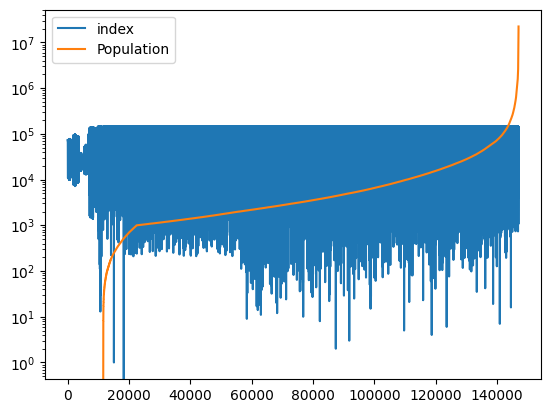

In [37]:
cdb.sort_values('Population').Population.reset_index().plot(logy=True) # elbow cut @ 20k inhabitants

<Axes: >

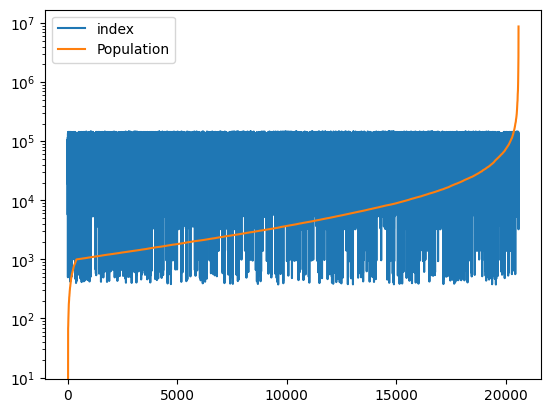

In [86]:
#US Only market
cdb[cdb['Country Code'].isin(['US','AU'])].sort_values('Population').Population.reset_index().plot(logy=True) # elbow cut @ 2k inhabitants isn't worth it

In [87]:
#cities of interest:
cof = cdb[cdb['Country Code'].isin(['US','AU'])]
cof = cof[cof['Population']>10000]

In [88]:
cof[cof.Name=='Newark'][['Name','Admin1 Code']]

,Name,Admin1 Code
954,Newark,DE
28123,Newark,OH
52466,Newark,NJ
84104,Newark,CA


## 2.2 US Cities

In [89]:
cities_path = './data/us-cities-demographics.csv'
usc = pd.read_csv(cities_path, sep=';', header=0)


In [90]:
USCODES = usc['State Code'].unique()

In [91]:
usc = usc[['City','State Code','Median Age','Male Population','Female Population','Foreign-born']].drop_duplicates()

In [92]:
merged_df = pd.merge(
    cof,
    usc,
    left_on=['Name', 'Admin1 Code'],
    right_on=['City', 'State Code'],
    how='left'
)

In [93]:
geo_df = merged_df[['ASCII Name', 'Alternate Names', 'Feature Class',
       'Feature Code', 'Country Code',
       'Admin1 Code', 'Population', 'Elevation','Timezone', 'Coordinates', 'City', 'State Code',
       'Median Age', 'Male Population', 'Female Population', 'Foreign-born']]

blacklist = ['Enterprise','Summit','Justice',"Mobile","Opportunity","Mission","Orange","March","Central"]


for wrd in blacklist:
    geo_df = geo_df[geo_df['ASCII Name']!=wrd]

## 2.3 Feature extraction

In [94]:
urls_df = pd.read_parquet("important_urls.parquet")

In [95]:
folder_path = "./data/hackathon_data/"# Google drive path of the dataset
files_in_folder = os.listdir(folder_path)
len(files_in_folder)

13144

In [96]:
urls_set = set(urls_df['url'])

In [97]:
def load_documents(json_file):
    """Loads the JSON file."""
    with open(json_file, 'r') as f:
      try:
          data = json.load(f)
          return data
      except json.JSONDecodeError:
          print(f"Error reading {json_file}, it may not be a valid JSON file.")
    return []

In [98]:
def load_text(file=files_in_folder[0]):
    print(file)
    urldocs=load_documents(folder_path+file)['text_by_page_url']
    urldocs = {k:v for k,v in urldocs.items() if k in urls_set}
    return urldocs.values()

In [103]:
import re
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
from tqdm import tqdm

# City list
cities = geo_df['ASCII Name'].values
cities_set = set(city.lower() for city in cities)

# Regex for Title Case OR ALL CAPS
pattern = re.compile(
    r'\b(?:' +
    '|'.join(
        rf'{re.escape(city.title())}|{re.escape(city.upper())}'
        for city in cities_set
    ) +
    r')\b'
)

# Match function — now returns position too
def contains_city(text: str) -> Tuple[bool, str, int]:
    match = pattern.search(text)
    if match:
        return True, match.group(0), match.start()
    return False, "", -1

# ✅ You asked to keep this unchanged — still works perfectly
def process_documents(documents: List[str], max_workers: int = 4):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        return list(tqdm(executor.map(contains_city, documents), total=len(documents), desc="Processing Docs"))

# Example documents
docs = load_text()

# Run it
results = process_documents(docs)

# Output results
found_cities = []
contexts = {}
for doc, (found, city, pos) in zip(docs, results):
    if found:
        found_cities.append(city)
        if city in contexts.keys(): # add context
            contexts[city] = contexts[city]+' '+doc[pos:pos+30]
        else: #create context
            contexts[city] = doc[pos:pos+30]
        #print(f"{city}, Context: {doc[pos:pos+30]}")

found_cities = np.array(found_cities)

# Get unique values and their counts
cvalues, ccounts = np.unique(found_cities, return_counts=True)

# Find the most frequent (mode)

most_frequent = cvalues[np.argmax(ccounts)]
top_context = contexts[most_frequent]


# Now check if in the context

# Build regex to match full words (case-sensitive)
pattern = re.compile(r'\b(?:' + '|'.join(re.escape(code) for code in USCODES) + r')\b')

# Find all matches
code_matches = pattern.findall(top_context)

# Find the most frequent one
if code_matches:
    values, counts = np.unique(code_matches, return_counts=True)
    found_state = values[np.argmax(counts)]
else:
    found_state = None

print(f'we are in {most_frequent}, {found_state}')

brewingz.com.json


Processing Docs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 7981.55it/s]

we are in Houston, None


## Now run it on the dataset

In [148]:
cities = geo_df['ASCII Name'].values
cities_set = set(city.lower() for city in cities)

def extract_location(baseurl=files_in_folder[0],max_workers=4,disabletqdm=True):
    # Documents
    docs = load_text(file=baseurl)
    
    # City list
    
    # Regex for Title Case OR ALL CAPS
    pattern = re.compile(
        r'\b(?:' +
        '|'.join(
            rf'{re.escape(city.title())}|{re.escape(city.upper())}'
            for city in cities_set
        ) +
        r')\b'
    )
    
    # Match function — now returns position too
    def contains_city(text: str) -> Tuple[bool, str, int]:
        match = pattern.search(text)
        if match:
            return True, match.group(0), match.start()
        return False, "", -1
    
    def process_documents(documents: List[str], max_workers: int = 4):
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            return list(tqdm(executor.map(contains_city, documents), total=len(documents), desc="Processing Docs", disable=disabletqdm))
    
    # Run it
    results = process_documents(docs,max_workers=max_workers)
    
    # Output results
    found_cities = []
    contexts = {}
    for doc, (found, city, pos) in zip(docs, results):
        if found:
            found_cities.append(city)
            if city in contexts.keys(): # add context
                contexts[city] = contexts[city]+' '+doc[pos:pos+30]
            else: #create context
                contexts[city] = doc[pos:pos+30]
            #print(f"{city}, Context: {doc[pos:pos+30]}")
    
    found_cities = np.array(found_cities)
    
    # Get unique values and their counts
    cvalues, ccounts = np.unique(found_cities, return_counts=True)
    cvalues_sorted = cvalues[np.argsort(-ccounts)]

    
    
    if len(ccounts) == 0:
        return {'city':None, 'state':None, 'context':None, 'num_cities': 0, 'top_cities': cvalues_sorted}
        
    # Find the most frequent (mode)
    most_frequent = cvalues[np.argmax(ccounts)]
    top_context = contexts[most_frequent]
    
    
    # Now check if in the context
  
    # Build regex to match full words (case-sensitive)
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(code) for code in USCODES) + r')\b')
    
    # Find all matches
    code_matches = pattern.findall(top_context)
    
    # Find the most frequent one
    if code_matches:
        values, counts = np.unique(code_matches, return_counts=True)
        found_state = values[np.argmax(counts)]
    else:
        found_state = None
    
    return {'city':most_frequent, 'state':found_state, 'context':top_context, 'num_cities': len(cvalues), 'top_cities': cvalues_sorted}

In [149]:
len(geo_df[geo_df['Elevation']==-1000])

0

In [151]:
for file in tqdm(files_in_folder[:]):
    info = extract_location(baseurl=file,max_workers=30)
    geodata = geo_df[(geo_df['ASCII Name']==info['city']) & (geo_df['Admin1 Code']==info['state'])]
    
    with open('./data/geofeature.csv', mode='a', newline='') as geo_out:
        writer = csv.writer(geo_out)
        writer.writerow([file,len(geodata),geodata.to_json() if len(geodata) > 0 else info['context'],info['num_cities'],info['top_cities']])
    

  0%|                                                                                                                                                        | 2/13144 [00:00<15:00, 14.60it/s]

brewingz.com.json
edgewoodproperties.com.json
sohomd.com.json


  0%|                                                                                                                                                        | 4/13144 [00:00<15:27, 14.17it/s]

russdaviswholesale.com.json
gothamgreens.com.json


  0%|                                                                                                                                                        | 6/13144 [00:00<24:29,  8.94it/s]

globecorporate.com.json
optics1.com.json
fluoresco.com.json


  0%|                                                                                                                                                        | 8/13144 [00:01<38:18,  5.72it/s]

firstlinesoftware.com.json


  0%|                                                                                                                                                        | 9/13144 [00:01<58:20,  3.75it/s]

thayermahan.com.json


  0%|                                                                                                                                                     | 10/13144 [00:02<1:14:44,  2.93it/s]

rizzle.com.json


  0%|                                                                                                                                                     | 11/13144 [00:02<1:22:42,  2.65it/s]

mortgagebrokermarketing.com.json


  0%|▏                                                                                                                                                    | 12/13144 [00:03<1:14:44,  2.93it/s]

avon-protection.com.json
bluezones.com.json


  0%|▏                                                                                                                                                    | 14/13144 [00:03<1:06:04,  3.31it/s]

coventry.com.json
paintthetown.com.json


  0%|▏                                                                                                                                                    | 16/13144 [00:04<1:05:49,  3.32it/s]

bellecares.com.json


  0%|▏                                                                                                                                                    | 17/13144 [00:04<1:15:12,  2.91it/s]

henryfordoptimeyes.com.json
bedsonline.com.json


  0%|▏                                                                                                                                                      | 20/13144 [00:05<53:09,  4.11it/s]

fsnursing.com.json
centricbiz.com.json


  0%|▏                                                                                                                                                    | 21/13144 [00:05<1:10:08,  3.12it/s]

carsonvalleyinn.com.json
texanacenter.com.json


  0%|▎                                                                                                                                                    | 23/13144 [00:06<1:14:39,  2.93it/s]

amcnetworks.com.json


  0%|▎                                                                                                                                                    | 23/13144 [00:06<1:04:38,  3.38it/s]

KeyboardInterrupt



2


## other...

13144

In [9]:
files_in_folder

['skysolutions.com.json',
 'richardsonsports.com.json',
 'wilson-company.com.json',
 'westernallied.com.json',
 'bluescopebuildings.com.json',
 'cobbemc.com.json',
 'is4s.com.json',
 'berkleyselect.com.json',
 'webbwheel.com.json',
 'sygmanetwork.com.json',
 'smma.com.json',
 'cgicontainersales.com.json',
 'nydig.com.json',
 'protranslating.com.json',
 'traditionalbank.com.json',
 'percona.com.json',
 'lawnlove.com.json',
 'elementsdesign.com.json',
 'pghwong.com.json',
 'fwcook.com.json',
 'sofistadium.com.json',
 'sfopera.com.json',
 'helenwellsagency.com.json',
 'russdaviswholesale.com.json',
 'irissoftware.com.json',
 'klarquist.com.json',
 'govtact.com.json',
 'lowlandsgroup.com.json',
 'kingseducation.com.json',
 'qualcareinc.com.json',
 'mymotomart.com.json',
 'chartbeat.com.json',
 'kongbasileconsulting.com.json',
 'javacity.com.json',
 'saintmarks.com.json',
 'finchpaper.com.json',
 'optoro.com.json',
 'paccarparts.com.json',
 'tendercarehh.com.json',
 'ftei.com.json',
 'lesse

In [34]:
for filename in files_in_folder:
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        doc = load_documents(file_path)
        break
print(doc.keys())

dict_keys(['url', 'timestamp', 'text_by_page_url', 'doc_id'])


## 2.2 Pre-process documents.

Feel free to explore and pre-process the data. You may want to clean or segment the documents as you see fit.

In [ ]:
def page_segment(docs):
    """You may prefer to load each page separately."""
    i = 0
    page_segment = []
    for s in list(docs['text_by_page_url'].values()):
      page_segment.append({"docID": docs['doc_id'], "pageID": 'page_' + str(i), "text": s})
      i += 1
    return page_segment

In [ ]:
def segment_documents(docs, chunk_size=500):
    """Segments documents into chunks of a given token size. Replace this function with your segmentation approach or maybe use the original document without segmentation."""
    segmented = []
    for doc_id, content in docs.items():
        for i in range(0, len(content), chunk_size):
            segment = content[i : i + chunk_size]
            segmented.append({"id": doc_id, "text": segment})
    return segmented



In [ ]:
def document_clean(docs):
  """
  You may want to clean the dataset, add the code here.
  """
  pass

## 2.3 Document Indexing and Storage (Profiling)

Feel free to choose different ways to indexing and storing the provided documents in a knowledge database.

So that they can be retrieved in different ways according to your system design choices, such as search by keywords, vector representation, graph relation, and etc.

# 3. Retrieval Augmented Generation

## 3.1 Load Knowledge Database

## 3.2 Relevant Document Retrieval

Feel free to check and improve your retrieval performance as it affect the generation results significantly.

In [ ]:
def retrieve_documents(query, db_path, embedding_model):
  """
  retrieve relevant documents from the knowledge database to the query.
  """
  return relevant_docs

## 3.3 Response Generation

Feel free to explore promp engineer to improve the quality of your generated response.

The retrieved documents are used as context to generate more relevant response. Gereral knowledge from the language model itself is also used.

In [ ]:
def generate_answer(query, retrieved_texts, prompt_template):
    """Generates an answer using retrieved documents and GPT-4."""
    return response

In [ ]:
query = "What company is located in 29010 Commerce Center Dr., Valencia, 91355, California, US?"
retrieved_docs = retrieve_documents(query, db_path, embedding_model)
response = generate_answer(query, retrieved_texts, prompt_template)

print("Query:", query)
print("Retrieved Documents:", [doc.page_content for doc in retrieved_docs])
print("Generated Answer:", response)

# 4. Evaluation

Try as many examples to evaluate your system and improve your performance!

As the final sysrtem will be evaluated from various aspects. Try to check different metrics when you evaluate. One trick is to do a "strict RAG" where the response is generated based on the retrieved documents only, i.e. no general knowledge from the LLMs will be used. This may be a good way to check if your retrieval part is working as expected. Note, that in the final system general knowledge from the LLMs are welcome. "Strict RAG" is only used as a way for you to check your performance :)

In [159]:
df = pd.read_csv("./data/geofeature.csv", header=None)
df.drop_duplicates(subset=[0])
df.to_csv("./data/geofeature.csv")